In [21]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

In [22]:
model = models.resnet50(pretrained=True)

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [24]:
def get_image(path, transform):
    '''
    get image from path and transform it tensor
    '''
    img = PIL.Image.open(path)
    img_t = transform(img)
    img_t = img_t.unsqueeze(0)
    img_it = transform(img)
    return img_t
img = get_image('images/nosacz.jpg', transform)
type(img), img.shape

(torch.Tensor, torch.Size([1, 3, 224, 224]))

In [25]:
target_layer = model.layer4[-1].conv3

activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

target_layer = model.layer4[-1].conv3
target_layer.register_forward_hook(forward_hook)
target_layer.register_full_backward_hook(backward_hook)

model.eval()
ouput = model(img)
pred_class = ouput.argmax().item()

model.zero_grad()
ouput[0, pred_class].backward()

gradients = gradients[0].cpu().data.numpy()
activations = activations[0].cpu().data.numpy()

weights = activations.mean(axis=(2, 3))

In [26]:
weights.shape

(1, 2048)

In [27]:
cam = np.zeros(activations.shape[2:], dtype=np.float32)

for i, w in enumerate(weights[0]):
    cam += w * activations[0, i, :, :]

cam = np.maximum(cam, 0)

heatmap = cv2.resize(cam, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255

In [28]:
img = img.squeeze(0).permute(1, 2, 0).numpy()

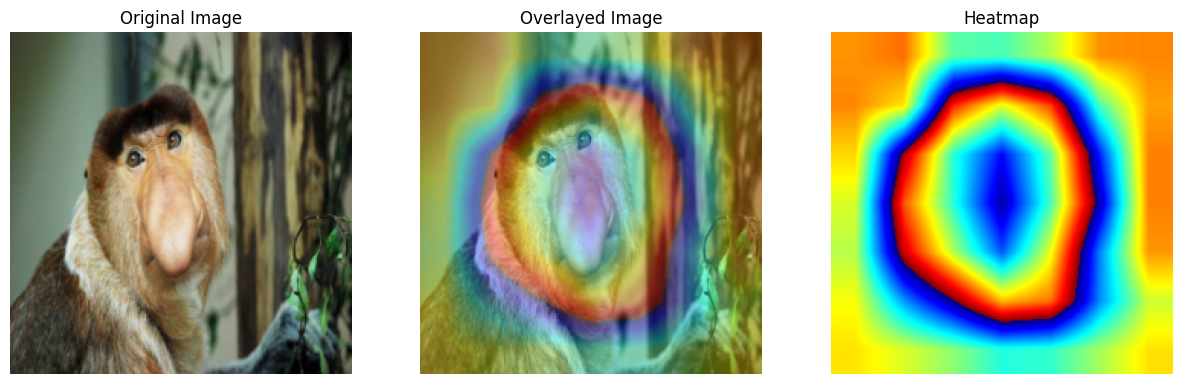

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[2].imshow(heatmap)
axs[2].set_title('Heatmap')
axs[2].axis('off')

overlayed_img = heatmap * 0.5 + img
overlayed_img = overlayed_img / overlayed_img.max()

axs[1].imshow(overlayed_img)
axs[1].set_title('Overlayed Image')
axs[1].axis('off')

plt.show()